## Reference to MoCo Demo: CIFAR-10

This is a simple demo for training MoCo on fingerprint dataset (SOCOFing fingerprint dataset from Kaggle). It can be run directly in a Colab notebook using a publicly available GPU.

#### Results

These are the ResNet-18 classification accuracy of a **kNN monitor** on the unsupervised pre-training features.

| config | 200ep | 400ep | 800ep |
| --- | --- | --- | --- |
| Asymmetric | 82.6 | 86.3 | 88.7 |
| Symmetric | 85.3 | 88.5 | 89.7 |

#### Notes

* **Symmetric loss**: the original MoCo paper uses an *asymmetric* loss -- one crop is the query and the other crop is the key, and it backpropagates to one crop (query). Following SimCLR/BYOL, here we provide an option of a *symmetric* loss -- it swaps the two crops and computes an extra loss. The symmetric loss behaves like 2x epochs of the asymmetric counterpart: this may dominate the comparison results when the models are trained with a fixed epoch number.

* **SplitBatchNorm**: the original MoCo was trained in 8 GPUs. To simulate the multi-GPU behavior of BatchNorm in this 1-GPU demo, we provide a SplitBatchNorm layer. We set `--bn-splits 8` by default to simulate 8 GPUs. `--bn-splits 1` is analogous to SyncBatchNorm in the multi-GPU case.

* **kNN monitor**: this demo provides a kNN monitor on the test set. Training a linear classifier on frozen features often achieves higher accuracy. To train a linear classifier (not provided in this demo), we recommend using lr=30, wd=0, epochs=100 with a stepwise or cosine schedule. The ResNet-18 model (kNN 89.7) has 90.7 linear classification accuracy.

#### Disclaimer

This demo aims to provide an interface with a free GPU (thanks to Colab) for understanding how the code runs. We suggest users be careful to draw conclusions from CIFAR, which may not generalize beyond this dataset. We have verified that it is beneficial to have the momentum encoder (disabling it by `--moco-m 0.0` should fail), queue size (saturated at `--moco-k 4096`) and ShuffleBN (without which loses 4% at 800 epochs) on CIFAR, similar to the observations on ImageNet. But new observations made only on CIFAR should be judged with caution.

#### References
This demo is adapted from:
* http://github.com/zhirongw/lemniscate.pytorch
* https://github.com/leftthomas/SimCLR
* [MoCo DEMO: CIFAR-10](https://colab.research.google.com/github/facebookresearch/moco/blob/colab-notebook/colab/moco_cifar10_demo.ipynb)
* [SOCOFing Dataset](https://www.kaggle.com/datasets/ruizgara/socofing)







### Prepare

Check GPU settings. A free GPU in Colab is <= Tesla P100. The log of the demo is based on a Tesla V100 from Google Cloud Platform.


In [1]:
gpu_info = !nvidia-smi -i 0
gpu_info = '\n'.join(gpu_info)
#print(gpu_info)

from datetime import datetime
from functools import partial
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10
from torchvision.models import resnet
from tqdm import tqdm
import argparse
import json
import math
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
# below added by Allen which is needed for custom dataset class
from PIL import Image
import pandas as pd
from scipy.io import loadmat
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import cv2

Sun Jul 16 05:33:15 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        Off | 00000000:01:00.0 Off |                  N/A |
| 59%   47C    P8              35W / 390W |     30MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Set arguments

In [2]:
parser = argparse.ArgumentParser(description='Train MoCo on CIFAR-10')

parser.add_argument('-a', '--arch', default='resnet18')

# lr: 0.06 for batch 512 (or 0.03 for batch 256)
parser.add_argument('--lr', '--learning-rate', default=0.06, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('--epochs', default=200, type=int, metavar='N', help='number of total epochs to run')
parser.add_argument('--epoch-size', default=31052, type=int,
                    help='size of training set to use (default:55270, size of SOCOFing fingerprint dataset)')
parser.add_argument('--classes', default=600, type=int,
                    help='Number of classes in the training set (default: 600)')
parser.add_argument('--schedule', default=[120, 160], nargs='*', type=int, help='learning rate schedule (when to drop lr by 10x); does not take effect if --cos is on')
parser.add_argument('--cos', action='store_true', help='use cosine lr schedule')

parser.add_argument('--batch-size', default=512, type=int, metavar='N', help='mini-batch size')
parser.add_argument('--wd', default=5e-4, type=float, metavar='W', help='weight decay')

# moco specific configs:
parser.add_argument('--moco-dim', default=128, type=int, help='feature dimension')
parser.add_argument('--moco-k', default=4096, type=int, help='queue size; number of negative keys')
parser.add_argument('--moco-m', default=0.99, type=float, help='moco momentum of updating key encoder')
parser.add_argument('--moco-t', default=0.1, type=float, help='softmax temperature')

parser.add_argument('--bn-splits', default=8, type=int, help='simulate multi-gpu behavior of BatchNorm in one gpu; 1 is SyncBatchNorm in multi-gpu')

parser.add_argument('--symmetric', action='store_true', help='use a symmetric loss function that backprops to both crops')

# knn monitor
parser.add_argument('--knn-k', default=200, type=int, help='k in kNN monitor')
parser.add_argument('--knn-t', default=0.1, type=float, help='softmax temperature in kNN monitor; could be different with moco-t')

# utils
parser.add_argument('--resume', default='', type=str, metavar='PATH', help='path to latest checkpoint (default: none)')

'''
args = parser.parse_args()  # running in command line
'''
args = parser.parse_args('')  # running in ipynb

# set command line arguments here when running in ipynb
args.epochs = 10
args.batch_size = 128
args.learning_rate = 0.03
#args.results_dir = os.path.join("model", "selfsup", "moco")
args.cos = True
args.schedule = []  # cos in use
args.symmetric = False
# if args.results_dir == '':
#     args.results_dir = './cache-' + datetime.now().strftime("%Y-%m-%d-%H-%M-%S-moco")

print(args)

Namespace(arch='resnet18', batch_size=128, bn_splits=8, classes=600, cos=True, epoch_size=31052, epochs=200, knn_k=200, knn_t=0.1, learning_rate=0.03, lr=0.06, moco_dim=128, moco_k=4096, moco_m=0.99, moco_t=0.1, resume='', schedule=[], symmetric=False, wd=0.0005)


In [3]:
# fingerprint dataset class
# 2023-3-12 custom dataset created by Allen LIN

class fingerprintDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.targets = self.img_labels.iloc[:, 1] # label of the dataset
        self.target_transform = target_transform
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    def __len__(self):
        return len(self.img_labels)

### Define data loaders

In [4]:
# class CIFAR10Pair(CIFAR10):
#     """CIFAR10 Dataset.
#     """
#     def __getitem__(self, index):
#         img = self.data[index]
#         img = Image.fromarray(img)

#         if self.transform is not None:
#             im_1 = self.transform(img)
#             im_2 = self.transform(img)

#         return im_1, im_2
class fingerprintPair(fingerprintDataset):
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            im_1 = self.transform(image)
            im_2 = self.transform(image)
        
        return im_1, im_2

train_transform = transforms.Compose([
    transforms.ToPILImage(), # to PIL format
    transforms.RandomResizedCrop(32),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomApply([transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor(),
    #transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    transforms.Normalize(mean=[0.5071], std=[0.4107])
])

test_transform = transforms.Compose([
    transforms.ToPILImage(), # to PIL format
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    #transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010])
    transforms.Normalize(mean=[0.5071], std=[0.4107])
])

training_annotations_file = os.path.join("kaggle_fingerprint", "kaggle_training_fingerprint_annotations.csv")
validation_annotations_file = os.path.join("kaggle_fingerprint", "kaggle_validation_fingerprint_annotations.csv")
img_dir = os.path.join("kaggle_fingerprint", "SOCOFing", "All")
# data prepare
#train_data = CIFAR10Pair(root='data', train=True, transform=train_transform, download=True)
train_data = fingerprintPair(training_annotations_file, img_dir, transform=train_transform)
train_loader = DataLoader(train_data, batch_size=args.batch_size, shuffle=True, num_workers=16, pin_memory=True, drop_last=True)

#memory_data = CIFAR10(root='data', train=True, transform=test_transform, download=True)
memory_data = fingerprintDataset(training_annotations_file, img_dir, transform=test_transform)
memory_loader = DataLoader(memory_data, batch_size=args.batch_size, shuffle=False, num_workers=16, pin_memory=True)

#test_data = CIFAR10(root='data', train=False, transform=test_transform, download=True)
test_data = fingerprintDataset(validation_annotations_file, img_dir, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=args.batch_size, shuffle=False, num_workers=16, pin_memory=True)


### Define base encoder

In [5]:
# SplitBatchNorm: simulate multi-gpu behavior of BatchNorm in one gpu by splitting alone the batch dimension
# implementation adapted from https://github.com/davidcpage/cifar10-fast/blob/master/torch_backend.py
class SplitBatchNorm(nn.BatchNorm2d):
    def __init__(self, num_features, num_splits, **kw):
        super().__init__(num_features, **kw)
        self.num_splits = num_splits

    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            running_mean_split = self.running_mean.repeat(self.num_splits)
            running_var_split = self.running_var.repeat(self.num_splits)
            outcome = nn.functional.batch_norm(
                input.view(-1, C * self.num_splits, H, W), running_mean_split, running_var_split,
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W)
            self.running_mean.data.copy_(running_mean_split.view(self.num_splits, C).mean(dim=0))
            self.running_var.data.copy_(running_var_split.view(self.num_splits, C).mean(dim=0))
            return outcome
        else:
            return nn.functional.batch_norm(
                input, self.running_mean, self.running_var,
                self.weight, self.bias, False, self.momentum, self.eps)

class ModelBase(nn.Module):
    """
    Common CIFAR ResNet recipe.
    Comparing with ImageNet ResNet recipe, it:
    (i) replaces conv1 with kernel=3, str=1
    (ii) removes pool1
    """
    def __init__(self, feature_dim=128, arch=None, bn_splits=16):
        super(ModelBase, self).__init__()

        # use split batchnorm
        norm_layer = partial(SplitBatchNorm, num_splits=bn_splits) if bn_splits > 1 else nn.BatchNorm2d
        resnet_arch = getattr(resnet, arch)
        net = resnet_arch(num_classes=feature_dim, norm_layer=norm_layer)

        self.net = []
        for name, module in net.named_children():
            if name == 'conv1':
                module = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
            if isinstance(module, nn.MaxPool2d):
                continue
            if isinstance(module, nn.Linear):
                self.net.append(nn.Flatten(1))
            self.net.append(module)

        self.net = nn.Sequential(*self.net)

    def forward(self, x):
        x = self.net(x)
        # note: not normalized here
        return x

### Define MoCo wrapper

In [6]:
class ModelMoCo(nn.Module):
    def __init__(self, dim=128, K=4096, m=0.99, T=0.1, arch='resnet18', bn_splits=8, symmetric=True, mlp=False):
        super(ModelMoCo, self).__init__()

        self.K = K
        self.m = m
        self.T = T
        self.symmetric = symmetric

        # create the encoders
        self.encoder_q = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits)
        self.encoder_k = ModelBase(feature_dim=dim, arch=arch, bn_splits=bn_splits)
        
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data.copy_(param_q.data)  # initialize
            param_k.requires_grad = False  # not update by gradient

        # create the queue
        self.register_buffer("queue", torch.randn(dim, K))
        self.queue = nn.functional.normalize(self.queue, dim=0)

        self.register_buffer("queue_ptr", torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_key_encoder(self):
        """
        Momentum update of the key encoder
        """
        for param_q, param_k in zip(self.encoder_q.parameters(), self.encoder_k.parameters()):
            param_k.data = param_k.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def _dequeue_and_enqueue(self, keys):
        batch_size = keys.shape[0]

        ptr = int(self.queue_ptr)
        assert self.K % batch_size == 0  # for simplicity

        # replace the keys at ptr (dequeue and enqueue)
        self.queue[:, ptr:ptr + batch_size] = keys.t()  # transpose
        ptr = (ptr + batch_size) % self.K  # move pointer

        self.queue_ptr[0] = ptr

    @torch.no_grad()
    def _batch_shuffle_single_gpu(self, x):
        """
        Batch shuffle, for making use of BatchNorm.
        """
        # random shuffle index
        idx_shuffle = torch.randperm(x.shape[0]).cuda()

        # index for restoring
        idx_unshuffle = torch.argsort(idx_shuffle)

        return x[idx_shuffle], idx_unshuffle

    @torch.no_grad()
    def _batch_unshuffle_single_gpu(self, x, idx_unshuffle):
        """
        Undo batch shuffle.
        """
        return x[idx_unshuffle]

    def contrastive_loss(self, im_q, im_k):
        # compute query features
        q = self.encoder_q(im_q)  # queries: NxC
        q = nn.functional.normalize(q, dim=1)  # already normalized

        # compute key features
        with torch.no_grad():  # no gradient to keys
            # shuffle for making use of BN
            im_k_, idx_unshuffle = self._batch_shuffle_single_gpu(im_k)

            k = self.encoder_k(im_k_)  # keys: NxC
            k = nn.functional.normalize(k, dim=1)  # already normalized

            # undo shuffle
            k = self._batch_unshuffle_single_gpu(k, idx_unshuffle)

        # compute logits
        # Einstein sum is more intuitive
        # positive logits: Nx1
        l_pos = torch.einsum('nc,nc->n', [q, k]).unsqueeze(-1)
        # negative logits: NxK
        l_neg = torch.einsum('nc,ck->nk', [q, self.queue.clone().detach()])

        # logits: Nx(1+K)
        logits = torch.cat([l_pos, l_neg], dim=1)

        # apply temperature
        logits /= self.T

        # labels: positive key indicators
        labels = torch.zeros(logits.shape[0], dtype=torch.long).cuda()

        loss = nn.CrossEntropyLoss().cuda()(logits, labels)

        return loss, q, k

    def forward(self, im1, im2):
        """
        Input:
            im_q: a batch of query images
            im_k: a batch of key images
        Output:
            loss
        """

        # update the key encoder
        with torch.no_grad():  # no gradient to keys
            self._momentum_update_key_encoder()

        # compute loss
        if self.symmetric:  # asymmetric loss
            loss_12, q1, k2 = self.contrastive_loss(im1, im2)
            loss_21, q2, k1 = self.contrastive_loss(im2, im1)
            loss = loss_12 + loss_21
            k = torch.cat([k1, k2], dim=0)
        else:  # asymmetric loss
            loss, q, k = self.contrastive_loss(im1, im2)

        self._dequeue_and_enqueue(k)

        return loss

# create model
model = ModelMoCo(
        dim=args.moco_dim,
        K=args.moco_k,
        m=args.moco_m,
        T=args.moco_t,
        arch=args.arch,
        bn_splits=args.bn_splits,
        symmetric=args.symmetric,
    ).cuda()
print(model.encoder_q)

ModelBase(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): SplitBatchNorm(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel

### Define train/test



In [7]:
# train for one epoch
def train(net, data_loader, train_optimizer, epoch, args):
    net.train()
    adjust_learning_rate(optimizer, epoch, args)

    total_loss, total_num, train_bar = 0.0, 0, tqdm(data_loader)
    for im_1, im_2 in train_bar:
        im_1, im_2 = im_1.cuda(non_blocking=True), im_2.cuda(non_blocking=True)

        loss = net(im_1, im_2)

        train_optimizer.zero_grad()
        loss.backward()
        train_optimizer.step()

        total_num += data_loader.batch_size
        total_loss += loss.item() * data_loader.batch_size
        train_bar.set_description('Train Epoch: [{}/{}], lr: {:.6f}, Loss: {:.4f}'.format(epoch, args.epochs, optimizer.param_groups[0]['lr'], total_loss / total_num))

    return total_loss / total_num

# lr scheduler for training
def adjust_learning_rate(optimizer, epoch, args):
    """Decay the learning rate based on schedule"""
    lr = args.lr
    if args.cos:  # cosine lr schedule
        lr *= 0.5 * (1. + math.cos(math.pi * epoch / args.epochs))
    else:  # stepwise lr schedule
        for milestone in args.schedule:
            lr *= 0.1 if epoch >= milestone else 1.
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [8]:
# test using a knn monitor
def test(net, memory_data_loader, test_data_loader, epoch, args):
    net.eval()
    #classes = len(memory_data_loader.dataset.classes)
    classes = 600
    total_top1, total_top5, total_num, feature_bank = 0.0, 0.0, 0, []
    with torch.no_grad():
        # generate feature bank
        for data, target in tqdm(memory_data_loader, desc='Feature extracting'):
            feature = net(data.cuda(non_blocking=True))
            feature = F.normalize(feature, dim=1)
            feature_bank.append(feature)
        # [D, N]
        feature_bank = torch.cat(feature_bank, dim=0).t().contiguous()
        # [N]
        feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank.device)
        # loop test data to predict the label by weighted knn search
        test_bar = tqdm(test_data_loader)
        for data, target in test_bar:
            data, target = data.cuda(non_blocking=True), target.cuda(non_blocking=True)
            feature = net(data)
            feature = F.normalize(feature, dim=1)

            pred_labels = knn_predict(feature, feature_bank, feature_labels, classes, args.knn_k, args.knn_t)

            total_num += data.size(0)
            total_top1 += (pred_labels[:, 0] == target).float().sum().item()
            test_bar.set_description('Test Epoch: [{}/{}] Acc@1:{:.2f}%'.format(epoch, args.epochs, total_top1 / total_num * 100))

    return total_top1 / total_num * 100

# knn monitor as in InstDisc https://arxiv.org/abs/1805.01978
# implementation follows http://github.com/zhirongw/lemniscate.pytorch and https://github.com/leftthomas/SimCLR
def knn_predict(feature, feature_bank, feature_labels, classes, knn_k, knn_t):
    # compute cos similarity between each feature vector and feature bank ---> [B, N]
    sim_matrix = torch.mm(feature, feature_bank)
    # [B, K]
    sim_weight, sim_indices = sim_matrix.topk(k=knn_k, dim=-1)
    # [B, K]
    sim_labels = torch.gather(feature_labels.expand(feature.size(0), -1), dim=-1, index=sim_indices)
    sim_weight = (sim_weight / knn_t).exp()

    # counts for each class
    one_hot_label = torch.zeros(feature.size(0) * knn_k, classes, device=sim_labels.device)
    # [B*K, C]
    one_hot_label = one_hot_label.scatter(dim=-1, index=sim_labels.view(-1, 1), value=1.0)
    # weighted score ---> [B, C]
    pred_scores = torch.sum(one_hot_label.view(feature.size(0), -1, classes) * sim_weight.unsqueeze(dim=-1), dim=1)

    pred_labels = pred_scores.argsort(dim=-1, descending=True)
    return pred_labels

In [9]:
def create_output_model_path(args, version=0):
    model_path = os.path.join('model', 'selfsup', 'moco',
                                  '{}-classes_{}-featureDim_{}-queueSize_{}-epochsize_{}-'
                                  'bsize_{}-tepochs_{}_{}'.format(
                                      args.arch, args.classes, args.moco_dim, args.moco_k, args.epoch_size, args.batch_size, args.epochs, version))

    if os.path.exists(model_path):
        return create_output_model_path(args, version=version + 1)
    else:
        os.makedirs(model_path)
        return model_path

### Start training

In [10]:
# to record best_acc
best_acc = 0.0
# define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, weight_decay=args.wd, momentum=0.9)

# load model if resume
epoch_start = 1
if args.resume is not '':
    checkpoint = torch.load(args.resume)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    epoch_start = checkpoint['epoch'] + 1
    print('Loaded from: {}'.format(args.resume))

model_path = create_output_model_path(args)
# logging
results = {'train_loss': [], 'test_acc@1': []}
# if not os.path.exists(args.results_dir):
#     os.mkdir(args.results_dir)
# dump args
with open(model_path + '/args.json', 'w') as fid:
    json.dump(args.__dict__, fid, indent=2)

# training loop
for epoch in range(epoch_start, args.epochs + 1):
    train_loss = train(model, train_loader, optimizer, epoch, args)
    results['train_loss'].append(train_loss)
    test_acc_1 = test(model.encoder_q, memory_loader, test_loader, epoch, args)
    results['test_acc@1'].append(test_acc_1)
    # save statistics
    data_frame = pd.DataFrame(data=results, index=range(epoch_start, epoch + 1))
    data_frame.to_csv(model_path + '/log.csv', index_label='epoch')
    # save checkpoint
    fname = 'checkpoint_{:04d}.path.tar'.format(epoch)
    checkpoint_name = os.path.join(model_path, fname)
    torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),}, checkpoint_name)
    # save model when better acc
    if test_acc_1 > best_acc:
        print(f"Best model found at epoch {epoch+1}, saving model")
        torch.save({'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer' : optimizer.state_dict(),}, model_path + '/model_best.pth')
        best_acc = test_acc_1

  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 2, saving model


  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 5, saving model


  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 6, saving model


  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 7, saving model


  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 8, saving model


  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 9, saving model


  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 10, saving model


Train Epoch: [10/200], lr: 0.059631, Loss: 4.9029: 100%|██████████| 242/242 [00:13<00:00, 18.29it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 11, saving model


Train Epoch: [11/200], lr: 0.059553, Loss: 4.7741: 100%|██████████| 242/242 [00:13<00:00, 18.26it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 12, saving model


Train Epoch: [12/200], lr: 0.059469, Loss: 4.6951: 100%|██████████| 242/242 [00:13<00:00, 18.28it/s]
Test Epoch: [12/200] Acc@1:11.59%: 100%|██████████| 31/31 [00:00<00:00, 46.08it/s]
Train Epoch: [13/200], lr: 0.059377, Loss: 4.6124: 100%|██████████| 242/242 [00:13<00:00, 18.35it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 14, saving model


Train Epoch: [14/200], lr: 0.059278, Loss: 4.5173: 100%|██████████| 242/242 [00:13<00:00, 18.29it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 15, saving model


Train Epoch: [15/200], lr: 0.059171, Loss: 4.4438: 100%|██████████| 242/242 [00:13<00:00, 18.31it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 16, saving model


Train Epoch: [16/200], lr: 0.059057, Loss: 4.3777: 100%|██████████| 242/242 [00:13<00:00, 18.27it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 17, saving model


Train Epoch: [17/200], lr: 0.058937, Loss: 4.3034: 100%|██████████| 242/242 [00:13<00:00, 18.29it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 18, saving model


Train Epoch: [18/200], lr: 0.058809, Loss: 4.2465: 100%|██████████| 242/242 [00:13<00:00, 18.25it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 19, saving model


Train Epoch: [19/200], lr: 0.058674, Loss: 4.1975: 100%|██████████| 242/242 [00:13<00:00, 18.28it/s]
Test Epoch: [19/200] Acc@1:30.58%: 100%|██████████| 31/31 [00:00<00:00, 43.93it/s]
Train Epoch: [20/200], lr: 0.058532, Loss: 4.1271: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 21, saving model


Train Epoch: [21/200], lr: 0.058383, Loss: 4.0457: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 22, saving model


Train Epoch: [22/200], lr: 0.058226, Loss: 3.9653: 100%|██████████| 242/242 [00:13<00:00, 18.26it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 23, saving model


Train Epoch: [23/200], lr: 0.058063, Loss: 3.9188: 100%|██████████| 242/242 [00:13<00:00, 18.24it/s]
Test Epoch: [23/200] Acc@1:41.25%: 100%|██████████| 31/31 [00:00<00:00, 43.59it/s]
Train Epoch: [24/200], lr: 0.057893, Loss: 3.8304: 100%|██████████| 242/242 [00:13<00:00, 18.25it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 25, saving model


Train Epoch: [25/200], lr: 0.057716, Loss: 3.7620: 100%|██████████| 242/242 [00:13<00:00, 18.26it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 26, saving model


Train Epoch: [26/200], lr: 0.057533, Loss: 3.6649: 100%|██████████| 242/242 [00:13<00:00, 18.28it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 27, saving model


Train Epoch: [27/200], lr: 0.057342, Loss: 3.6209: 100%|██████████| 242/242 [00:13<00:00, 18.28it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 28, saving model


Train Epoch: [28/200], lr: 0.057145, Loss: 3.5682: 100%|██████████| 242/242 [00:13<00:00, 18.28it/s]
Test Epoch: [28/200] Acc@1:53.97%: 100%|██████████| 31/31 [00:00<00:00, 45.47it/s]
Train Epoch: [29/200], lr: 0.056941, Loss: 3.5038: 100%|██████████| 242/242 [00:13<00:00, 18.24it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 30, saving model


Train Epoch: [30/200], lr: 0.056730, Loss: 3.4635: 100%|██████████| 242/242 [00:13<00:00, 18.27it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 31, saving model


Train Epoch: [31/200], lr: 0.056513, Loss: 3.4220: 100%|██████████| 242/242 [00:13<00:00, 18.25it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 32, saving model


Train Epoch: [32/200], lr: 0.056289, Loss: 3.3758: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
Test Epoch: [32/200] Acc@1:55.63%: 100%|██████████| 31/31 [00:00<00:00, 45.54it/s]
Train Epoch: [33/200], lr: 0.056059, Loss: 3.3618: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [33/200] Acc@1:53.97%: 100%|██████████| 31/31 [00:00<00:00, 43.81it/s]
Train Epoch: [34/200], lr: 0.055822, Loss: 3.3004: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 35, saving model


Train Epoch: [35/200], lr: 0.055579, Loss: 3.2694: 100%|██████████| 242/242 [00:13<00:00, 18.26it/s]
Test Epoch: [35/200] Acc@1:56.68%: 100%|██████████| 31/31 [00:00<00:00, 43.66it/s]
Train Epoch: [36/200], lr: 0.055330, Loss: 3.2445: 100%|██████████| 242/242 [00:13<00:00, 18.21it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 37, saving model


Train Epoch: [37/200], lr: 0.055074, Loss: 3.2352: 100%|██████████| 242/242 [00:13<00:00, 18.25it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 38, saving model


Train Epoch: [38/200], lr: 0.054812, Loss: 3.2006: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [38/200] Acc@1:57.34%: 100%|██████████| 31/31 [00:00<00:00, 44.59it/s]
Train Epoch: [39/200], lr: 0.054544, Loss: 3.1597: 100%|██████████| 242/242 [00:13<00:00, 18.24it/s]
Test Epoch: [39/200] Acc@1:56.65%: 100%|██████████| 31/31 [00:00<00:00, 43.52it/s]
Train Epoch: [40/200], lr: 0.054271, Loss: 3.1322: 100%|██████████| 242/242 [00:13<00:00, 18.21it/s]
Test Epoch: [40/200] Acc@1:58.11%: 100%|██████████| 31/31 [00:00<00:00, 44.01it/s]
Train Epoch: [41/200], lr: 0.053991, Loss: 3.1088: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
Test Epoch: [41/200] Acc@1:58.57%: 100%|██████████| 31/31 [00:00<00:00, 44.98it/s]
Train Epoch: [42/200], lr: 0.053705, Loss: 3.1025: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 43, saving model


Train Epoch: [43/200], lr: 0.053413, Loss: 3.0708: 100%|██████████| 242/242 [00:13<00:00, 18.25it/s]
Test Epoch: [43/200] Acc@1:59.49%: 100%|██████████| 31/31 [00:00<00:00, 44.96it/s]
Train Epoch: [44/200], lr: 0.053115, Loss: 3.0736: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 45, saving model


Train Epoch: [45/200], lr: 0.052812, Loss: 3.0369: 100%|██████████| 242/242 [00:13<00:00, 18.25it/s]
Test Epoch: [45/200] Acc@1:59.37%: 100%|██████████| 31/31 [00:00<00:00, 46.15it/s]
Train Epoch: [46/200], lr: 0.052503, Loss: 3.0118: 100%|██████████| 242/242 [00:13<00:00, 18.18it/s]
Test Epoch: [46/200] Acc@1:61.80%: 100%|██████████| 31/31 [00:00<00:00, 43.75it/s]
Train Epoch: [47/200], lr: 0.052189, Loss: 2.9971: 100%|██████████| 242/242 [00:13<00:00, 18.18it/s]
Test Epoch: [47/200] Acc@1:62.26%: 100%|██████████| 31/31 [00:00<00:00, 45.27it/s]
Train Epoch: [48/200], lr: 0.051869, Loss: 3.0025: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
Test Epoch: [48/200] Acc@1:61.31%: 100%|██████████| 31/31 [00:00<00:00, 44.68it/s]
Train Epoch: [49/200], lr: 0.051544, Loss: 2.9802: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
Test Epoch: [49/200] Acc@1:60.36%: 100%|██████████| 31/31 [00:00<00:00, 44.56it/s]
Train Epoch: [50/200], lr: 0.051213, Loss: 2.9671: 100%|██████████| 242/242 [00:

Best model found at epoch 52, saving model


Train Epoch: [52/200], lr: 0.050536, Loss: 2.9175: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
Test Epoch: [52/200] Acc@1:61.51%: 100%|██████████| 31/31 [00:00<00:00, 41.25it/s]
Train Epoch: [53/200], lr: 0.050190, Loss: 2.8906: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [53/200] Acc@1:61.92%: 100%|██████████| 31/31 [00:00<00:00, 43.51it/s]
Train Epoch: [54/200], lr: 0.049839, Loss: 2.9057: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 55, saving model


Train Epoch: [55/200], lr: 0.049483, Loss: 2.8616: 100%|██████████| 242/242 [00:13<00:00, 18.26it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 56, saving model


Train Epoch: [56/200], lr: 0.049123, Loss: 2.8824: 100%|██████████| 242/242 [00:13<00:00, 18.17it/s]
Test Epoch: [56/200] Acc@1:61.87%: 100%|██████████| 31/31 [00:00<00:00, 45.82it/s]
Train Epoch: [57/200], lr: 0.048757, Loss: 2.8663: 100%|██████████| 242/242 [00:13<00:00, 18.15it/s]
Test Epoch: [57/200] Acc@1:61.05%: 100%|██████████| 31/31 [00:00<00:00, 44.67it/s]
Train Epoch: [58/200], lr: 0.048387, Loss: 2.8634: 100%|██████████| 242/242 [00:13<00:00, 18.21it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 59, saving model


Train Epoch: [59/200], lr: 0.048013, Loss: 2.8293: 100%|██████████| 242/242 [00:13<00:00, 18.26it/s]
Test Epoch: [59/200] Acc@1:61.80%: 100%|██████████| 31/31 [00:00<00:00, 46.14it/s]
Train Epoch: [60/200], lr: 0.047634, Loss: 2.8395: 100%|██████████| 242/242 [00:13<00:00, 18.18it/s]
Test Epoch: [60/200] Acc@1:61.51%: 100%|██████████| 31/31 [00:00<00:00, 45.62it/s]
Train Epoch: [61/200], lr: 0.047250, Loss: 2.8094: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [61/200] Acc@1:63.72%: 100%|██████████| 31/31 [00:00<00:00, 43.37it/s]
Train Epoch: [62/200], lr: 0.046863, Loss: 2.8150: 100%|██████████| 242/242 [00:13<00:00, 18.21it/s]
Test Epoch: [62/200] Acc@1:62.26%: 100%|██████████| 31/31 [00:00<00:00, 44.32it/s]
Train Epoch: [63/200], lr: 0.046471, Loss: 2.7812: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [63/200] Acc@1:63.31%: 100%|██████████| 31/31 [00:00<00:00, 45.55it/s]
Train Epoch: [64/200], lr: 0.046075, Loss: 2.7858: 100%|██████████| 242/242 [00:

Best model found at epoch 66, saving model


Train Epoch: [66/200], lr: 0.045271, Loss: 2.7681: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [66/200] Acc@1:62.82%: 100%|██████████| 31/31 [00:00<00:00, 45.32it/s]
Train Epoch: [67/200], lr: 0.044864, Loss: 2.7697: 100%|██████████| 242/242 [00:13<00:00, 18.25it/s]
Test Epoch: [67/200] Acc@1:64.51%: 100%|██████████| 31/31 [00:00<00:00, 45.23it/s]
Train Epoch: [68/200], lr: 0.044453, Loss: 2.7469: 100%|██████████| 242/242 [00:13<00:00, 18.25it/s]
Test Epoch: [68/200] Acc@1:63.31%: 100%|██████████| 31/31 [00:00<00:00, 43.92it/s]
Train Epoch: [69/200], lr: 0.044038, Loss: 2.7297: 100%|██████████| 242/242 [00:13<00:00, 18.16it/s]
Test Epoch: [69/200] Acc@1:62.95%: 100%|██████████| 31/31 [00:00<00:00, 44.72it/s]
Train Epoch: [70/200], lr: 0.043620, Loss: 2.7238: 100%|██████████| 242/242 [00:13<00:00, 18.21it/s]
Test Epoch: [70/200] Acc@1:64.51%: 100%|██████████| 31/31 [00:00<00:00, 44.45it/s]
Train Epoch: [71/200], lr: 0.043198, Loss: 2.7125: 100%|██████████| 242/242 [00:

Best model found at epoch 85, saving model


Train Epoch: [85/200], lr: 0.037003, Loss: 2.5960: 100%|██████████| 242/242 [00:13<00:00, 18.20it/s]
Test Epoch: [85/200] Acc@1:65.92%: 100%|██████████| 31/31 [00:00<00:00, 44.10it/s]
Train Epoch: [86/200], lr: 0.036544, Loss: 2.5921: 100%|██████████| 242/242 [00:13<00:00, 18.25it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 87, saving model


Train Epoch: [87/200], lr: 0.036084, Loss: 2.5578: 100%|██████████| 242/242 [00:13<00:00, 18.26it/s]
Test Epoch: [87/200] Acc@1:66.07%: 100%|██████████| 31/31 [00:00<00:00, 45.17it/s]
Train Epoch: [88/200], lr: 0.035621, Loss: 2.5718: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
Test Epoch: [88/200] Acc@1:63.87%: 100%|██████████| 31/31 [00:00<00:00, 45.22it/s]
Train Epoch: [89/200], lr: 0.035158, Loss: 2.5690: 100%|██████████| 242/242 [00:13<00:00, 18.18it/s]
Test Epoch: [89/200] Acc@1:64.07%: 100%|██████████| 31/31 [00:00<00:00, 45.58it/s]
Train Epoch: [90/200], lr: 0.034693, Loss: 2.5580: 100%|██████████| 242/242 [00:13<00:00, 18.27it/s]
Test Epoch: [90/200] Acc@1:64.66%: 100%|██████████| 31/31 [00:00<00:00, 44.07it/s]
Train Epoch: [91/200], lr: 0.034227, Loss: 2.5354: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [91/200] Acc@1:65.02%: 100%|██████████| 31/31 [00:00<00:00, 44.73it/s]
Train Epoch: [92/200], lr: 0.033760, Loss: 2.5272: 100%|██████████| 242/242 [00:

Best model found at epoch 104, saving model


Train Epoch: [104/200], lr: 0.028116, Loss: 2.4404: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [104/200] Acc@1:66.86%: 100%|██████████| 31/31 [00:00<00:00, 44.66it/s]
Train Epoch: [105/200], lr: 0.027646, Loss: 2.4261: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
Test Epoch: [105/200] Acc@1:65.56%: 100%|██████████| 31/31 [00:00<00:00, 44.79it/s]
Train Epoch: [106/200], lr: 0.027177, Loss: 2.4124: 100%|██████████| 242/242 [00:13<00:00, 18.21it/s]
Test Epoch: [106/200] Acc@1:66.17%: 100%|██████████| 31/31 [00:00<00:00, 45.54it/s]
Train Epoch: [107/200], lr: 0.026708, Loss: 2.4163: 100%|██████████| 242/242 [00:13<00:00, 18.24it/s]
Test Epoch: [107/200] Acc@1:65.46%: 100%|██████████| 31/31 [00:00<00:00, 43.32it/s]
Train Epoch: [108/200], lr: 0.026240, Loss: 2.3902: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [108/200] Acc@1:64.66%: 100%|██████████| 31/31 [00:00<00:00, 44.64it/s]
Train Epoch: [109/200], lr: 0.025773, Loss: 2.4200: 100%|██████████| 2

Best model found at epoch 113, saving model


Train Epoch: [113/200], lr: 0.023916, Loss: 2.3666: 100%|██████████| 242/242 [00:13<00:00, 18.24it/s]
Test Epoch: [113/200] Acc@1:66.17%: 100%|██████████| 31/31 [00:00<00:00, 44.29it/s]
Train Epoch: [114/200], lr: 0.023456, Loss: 2.3608: 100%|██████████| 242/242 [00:13<00:00, 18.24it/s]
Test Epoch: [114/200] Acc@1:65.97%: 100%|██████████| 31/31 [00:00<00:00, 43.25it/s]
Train Epoch: [115/200], lr: 0.022997, Loss: 2.3559: 100%|██████████| 242/242 [00:13<00:00, 18.25it/s]
Test Epoch: [115/200] Acc@1:65.12%: 100%|██████████| 31/31 [00:00<00:00, 45.53it/s]
Train Epoch: [116/200], lr: 0.022539, Loss: 2.3546: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [116/200] Acc@1:64.28%: 100%|██████████| 31/31 [00:00<00:00, 42.76it/s]
Train Epoch: [117/200], lr: 0.022084, Loss: 2.3541: 100%|██████████| 242/242 [00:13<00:00, 18.24it/s]
Test Epoch: [117/200] Acc@1:65.69%: 100%|██████████| 31/31 [00:00<00:00, 45.37it/s]
Train Epoch: [118/200], lr: 0.021630, Loss: 2.3486: 100%|██████████| 2

Best model found at epoch 138, saving model


Train Epoch: [138/200], lr: 0.013137, Loss: 2.1866: 100%|██████████| 242/242 [00:13<00:00, 18.20it/s]
Test Epoch: [138/200] Acc@1:67.25%: 100%|██████████| 31/31 [00:00<00:00, 44.61it/s]
Train Epoch: [139/200], lr: 0.012750, Loss: 2.1723: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
Test Epoch: [139/200] Acc@1:66.04%: 100%|██████████| 31/31 [00:00<00:00, 44.82it/s]
Train Epoch: [140/200], lr: 0.012366, Loss: 2.1629: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [140/200] Acc@1:66.89%: 100%|██████████| 31/31 [00:00<00:00, 44.34it/s]
Train Epoch: [141/200], lr: 0.011987, Loss: 2.1583: 100%|██████████| 242/242 [00:13<00:00, 18.25it/s]
Test Epoch: [141/200] Acc@1:68.09%: 100%|██████████| 31/31 [00:00<00:00, 45.82it/s]
Train Epoch: [142/200], lr: 0.011613, Loss: 2.1526: 100%|██████████| 242/242 [00:13<00:00, 18.20it/s]
Test Epoch: [142/200] Acc@1:68.30%: 100%|██████████| 31/31 [00:00<00:00, 44.53it/s]
Train Epoch: [143/200], lr: 0.011243, Loss: 2.1369: 100%|██████████| 2

Best model found at epoch 145, saving model


Train Epoch: [145/200], lr: 0.010517, Loss: 2.1146: 100%|██████████| 242/242 [00:13<00:00, 18.20it/s]
Test Epoch: [145/200] Acc@1:67.76%: 100%|██████████| 31/31 [00:00<00:00, 44.65it/s]
Train Epoch: [146/200], lr: 0.010161, Loss: 2.1058: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [146/200] Acc@1:66.81%: 100%|██████████| 31/31 [00:00<00:00, 43.71it/s]
Train Epoch: [147/200], lr: 0.009810, Loss: 2.1047: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [147/200] Acc@1:67.60%: 100%|██████████| 31/31 [00:00<00:00, 45.00it/s]
Train Epoch: [148/200], lr: 0.009464, Loss: 2.1109: 100%|██████████| 242/242 [00:13<00:00, 18.21it/s]
Test Epoch: [148/200] Acc@1:67.68%: 100%|██████████| 31/31 [00:00<00:00, 43.87it/s]
Train Epoch: [149/200], lr: 0.009123, Loss: 2.0973: 100%|██████████| 242/242 [00:13<00:00, 18.18it/s]
Test Epoch: [149/200] Acc@1:68.24%: 100%|██████████| 31/31 [00:00<00:00, 44.44it/s]
Train Epoch: [150/200], lr: 0.008787, Loss: 2.0746: 100%|██████████| 2

Best model found at epoch 153, saving model


Train Epoch: [153/200], lr: 0.007811, Loss: 2.0412: 100%|██████████| 242/242 [00:13<00:00, 18.21it/s]
Test Epoch: [153/200] Acc@1:68.37%: 100%|██████████| 31/31 [00:00<00:00, 45.06it/s]
Train Epoch: [154/200], lr: 0.007497, Loss: 2.0497: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
Test Epoch: [154/200] Acc@1:67.53%: 100%|██████████| 31/31 [00:00<00:00, 45.83it/s]
Train Epoch: [155/200], lr: 0.007188, Loss: 2.0518: 100%|██████████| 242/242 [00:13<00:00, 18.19it/s]
Test Epoch: [155/200] Acc@1:66.63%: 100%|██████████| 31/31 [00:00<00:00, 43.26it/s]
Train Epoch: [156/200], lr: 0.006885, Loss: 2.0352: 100%|██████████| 242/242 [00:13<00:00, 18.25it/s]
Test Epoch: [156/200] Acc@1:66.43%: 100%|██████████| 31/31 [00:00<00:00, 42.92it/s]
Train Epoch: [157/200], lr: 0.006587, Loss: 2.0234: 100%|██████████| 242/242 [00:13<00:00, 18.24it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 158, saving model


Train Epoch: [158/200], lr: 0.006295, Loss: 2.0120: 100%|██████████| 242/242 [00:13<00:00, 18.21it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 159, saving model


Train Epoch: [159/200], lr: 0.006009, Loss: 2.0088: 100%|██████████| 242/242 [00:13<00:00, 18.19it/s]
Test Epoch: [159/200] Acc@1:68.91%: 100%|██████████| 31/31 [00:00<00:00, 44.41it/s]
Train Epoch: [160/200], lr: 0.005729, Loss: 1.9847: 100%|██████████| 242/242 [00:13<00:00, 18.18it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 161, saving model


Train Epoch: [161/200], lr: 0.005456, Loss: 1.9768: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [161/200] Acc@1:69.04%: 100%|██████████| 31/31 [00:00<00:00, 45.10it/s]
Train Epoch: [162/200], lr: 0.005188, Loss: 1.9786: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [162/200] Acc@1:68.94%: 100%|██████████| 31/31 [00:00<00:00, 43.41it/s]
Train Epoch: [163/200], lr: 0.004926, Loss: 1.9773: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [163/200] Acc@1:68.94%: 100%|██████████| 31/31 [00:00<00:00, 45.46it/s]
Train Epoch: [164/200], lr: 0.004670, Loss: 1.9678: 100%|██████████| 242/242 [00:13<00:00, 18.21it/s]
Test Epoch: [164/200] Acc@1:68.27%: 100%|██████████| 31/31 [00:00<00:00, 43.31it/s]
Train Epoch: [165/200], lr: 0.004421, Loss: 1.9699: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
Test Epoch: [165/200] Acc@1:68.47%: 100%|██████████| 31/31 [00:00<00:00, 44.85it/s]
Train Epoch: [166/200], lr: 0.004178, Loss: 1.9529: 100%|██████████| 2

Best model found at epoch 175, saving model


Train Epoch: [175/200], lr: 0.002284, Loss: 1.8882: 100%|██████████| 242/242 [00:13<00:00, 18.24it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 176, saving model


Train Epoch: [176/200], lr: 0.002107, Loss: 1.8895: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 177, saving model


Train Epoch: [177/200], lr: 0.001937, Loss: 1.8782: 100%|██████████| 242/242 [00:13<00:00, 18.20it/s]
Test Epoch: [177/200] Acc@1:69.81%: 100%|██████████| 31/31 [00:00<00:00, 44.63it/s]
Train Epoch: [178/200], lr: 0.001774, Loss: 1.8601: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [178/200] Acc@1:69.34%: 100%|██████████| 31/31 [00:00<00:00, 44.20it/s]
Train Epoch: [179/200], lr: 0.001617, Loss: 1.8634: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [179/200] Acc@1:68.81%: 100%|██████████| 31/31 [00:00<00:00, 45.38it/s]
Train Epoch: [180/200], lr: 0.001468, Loss: 1.8518: 100%|██████████| 242/242 [00:13<00:00, 18.22it/s]
Test Epoch: [180/200] Acc@1:68.63%: 100%|██████████| 31/31 [00:00<00:00, 44.81it/s]
Train Epoch: [181/200], lr: 0.001326, Loss: 1.8607: 100%|██████████| 242/242 [00:13<00:00, 18.24it/s]
Test Epoch: [181/200] Acc@1:69.19%: 100%|██████████| 31/31 [00:00<00:00, 45.45it/s]
Train Epoch: [182/200], lr: 0.001191, Loss: 1.8547: 100%|██████████| 2

Best model found at epoch 187, saving model


Train Epoch: [187/200], lr: 0.000623, Loss: 1.8285: 100%|██████████| 242/242 [00:13<00:00, 18.24it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 188, saving model


Train Epoch: [188/200], lr: 0.000531, Loss: 1.8210: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
  0%|          | 0/242 [00:00<?, ?it/s]

Best model found at epoch 189, saving model


Train Epoch: [189/200], lr: 0.000447, Loss: 1.8169: 100%|██████████| 242/242 [00:13<00:00, 18.25it/s]
Test Epoch: [189/200] Acc@1:70.01%: 100%|██████████| 31/31 [00:00<00:00, 44.98it/s]
Train Epoch: [190/200], lr: 0.000369, Loss: 1.8145: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
Test Epoch: [190/200] Acc@1:70.11%: 100%|██████████| 31/31 [00:00<00:00, 42.55it/s]
Train Epoch: [191/200], lr: 0.000299, Loss: 1.8179: 100%|██████████| 242/242 [00:13<00:00, 18.17it/s]
Test Epoch: [191/200] Acc@1:70.06%: 100%|██████████| 31/31 [00:00<00:00, 42.52it/s]
Train Epoch: [192/200], lr: 0.000237, Loss: 1.8036: 100%|██████████| 242/242 [00:13<00:00, 18.27it/s]
Test Epoch: [192/200] Acc@1:70.14%: 100%|██████████| 31/31 [00:00<00:00, 44.64it/s]
Train Epoch: [193/200], lr: 0.000181, Loss: 1.7992: 100%|██████████| 242/242 [00:13<00:00, 18.23it/s]
Test Epoch: [193/200] Acc@1:70.14%: 100%|██████████| 31/31 [00:00<00:00, 45.23it/s]
Train Epoch: [194/200], lr: 0.000133, Loss: 1.8032: 100%|██████████| 2

In [30]:
def save_loss(train_loss, save_path):
    plt.clf()  # Clear the figure
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title("Loss")
    plt.plot(train_loss,  label = "Training") # training loss curve
    #plt.plot(test_loss,  label = "Validation") # training loss curve
    plt.legend(loc = 'upper left')
    plt.savefig(save_path, bbox_inches='tight')
    
def save_acc(test_acc, save_path):
    plt.clf()  # Clear the figure
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy(%)')
    plt.title("Accuracy (knn_predict)")
    #plt.plot(train_acc,  label = "Training") # training loss curve
    plt.plot(test_acc,  label = "Validation") # training loss curve
    plt.legend(loc = 'upper left')
    plt.savefig(save_path, bbox_inches='tight')
    
def save_result_fig(args, name, version=0):
    result_path = os.path.join('results', "Allen's Result", "SOCOFing_Fingerprint", "MoCo", "Training",
                                  '{}-classes_{}-featureDim_{}-queueSize_{}-epochsize_{}-'
                                  'bsize_{}-tepochs_{}_{}-{}.jpg'.format(
                                      args.arch, args.classes, args.moco_dim, args.moco_k, args.epoch_size, args.batch_size, args.epochs, version, name))
    if os.path.exists(result_path):
        return save_result_fig(args, name, version+1)
    else:    
        return result_path

## Draw the Training and Validation graph

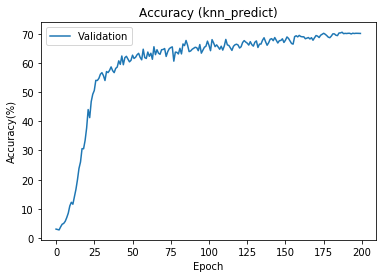

In [31]:
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv(os.path.join(model_path, "log.csv"))


#將訓練結果存起來
fig_loss_path = save_result_fig(args, "Loss")
fig_loss = save_loss(data['train_loss'], fig_loss_path)
fig_acc_path = save_result_fig(args, "Acc")
fig_acc = save_acc(data['test_acc@1'], fig_acc_path)